#### Imports

In [5]:
import pandas as pd
from ggplot import *

C:\Users\Luiz Henrique\Anaconda3\lib\site-packages\ggplot\components\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\Luiz Henrique\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Loading Offers from excel file 

In [6]:
df_offers = pd.read_excel("WineKMC.xlsx", sheet_name=0)

#### Changing the names of columns to be more concise

In [7]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty",
                    "discount", "origin", "past_peak"]
df_offers.head()

offer_id  campaign            varietal  min_qty  discount       origin  \
0         1   January              Malbec       72        56       France   
1         2   January          Pinot Noir       72        17       France   
2         3  February           Espumante      144        32       Oregon   
3         4  February           Champagne       72        48       France   
4         5  February  Cabernet Sauvignon      144        44  New Zealand   

   past_peak  
0      False  
1      False  
2       True  
3       True  
4       True

#### Loading the data about customers transactions

In [8]:
df_transactions = pd.read_excel("WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

customer_name  offer_id  n
0         Smith         2  1
1         Smith        24  1
2       Johnson        17  1
3       Johnson        24  1
4       Johnson        26  1

#### Merging dataframes

In [9]:
merged_df = pd.merge(df_offers, df_transactions)

#### Creating a pivot table crossing data about customers and transactions

In [10]:
matrix = merged_df.pivot_table(index=['customer_name'], columns=['offer_id'],
                              values='n')

#### Filling NA values with zero (customers that did not buy a product would have NA values)

In [11]:
matrix = matrix.fillna(0).reset_index()

#### Selecting the variable of interest

In [12]:
x_columns = matrix.columns[1:]

In [13]:
from sklearn.cluster import KMeans

#### Creating a KMeans model and fitting it with the data, then predicting the clusters

In [14]:
cluster = KMeans(n_clusters=5)
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])
matrix['cluster'].value_counts()

0    32
2    24
4    20
1    13
3    11
Name: cluster, dtype: int64

####  Reducing features dimentionality to be able to plot the results in a 2D representation

In [15]:
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=2)

In [17]:
matrix['x'] = pca.fit_transform(matrix[x_columns])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_columns])[:,1]
matrix = matrix.reset_index()

In [18]:
matrix.head()

offer_id  index customer_name    1    2    3    4    5    6    7    8  \
0             0         Adams  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1             1         Allen  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2             2      Anderson  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3             3        Bailey  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
4             4         Baker  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

offer_id    ...      26   27   28   29   30   31   32  cluster         x  \
0           ...     0.0  0.0  0.0  1.0  1.0  0.0  0.0        2  1.007580   
1           ...     0.0  1.0  0.0  0.0  0.0  0.0  0.0        0 -0.287539   
2           ...     1.0  0.0  0.0  0.0  0.0  0.0  0.0        1 -0.392032   
3           ...     0.0  0.0  0.0  0.0  1.0  0.0  0.0        2  0.699477   
4           ...     0.0  0.0  0.0  0.0  0.0  1.0  0.0        3  0.088183   

offer_id         y  
0         0.108215  
1         0.044715  
2         1.038391  
3        -0.022542  
4        -0.471695  

[5 rows x 37 columns]

In [19]:
customer_clusters = matrix[['customer_name', 'cluster', 'x', 'y']]

In [20]:
customer_clusters.head()

offer_id customer_name  cluster         x         y
0                Adams        2  1.007580  0.108215
1                Allen        0 -0.287539  0.044715
2             Anderson        1 -0.392032  1.038391
3               Bailey        2  0.699477 -0.022542
4                Baker        3  0.088183 -0.471695

#### Plotting clusters

In [21]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)

C:\Users\Luiz Henrique\Anaconda3\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


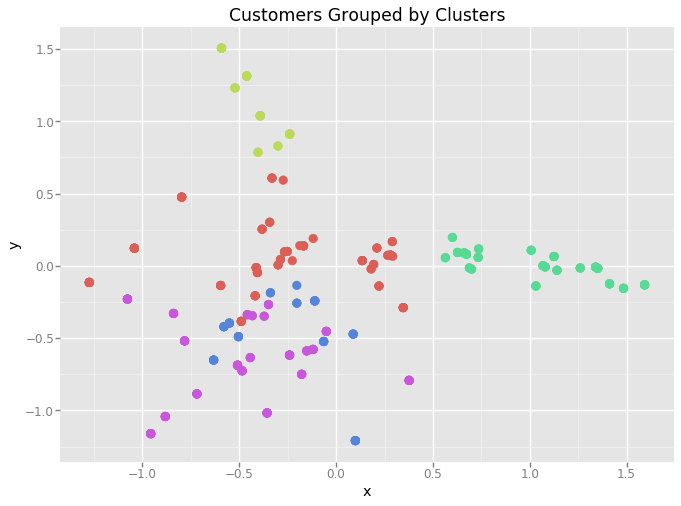

<ggplot: (-9223371952505781048)>

In [22]:
ggplot(df, aes(x='x', y='y', color='cluster')) + \
geom_point(size=75) + \
ggtitle("Customers Grouped by Clusters")

#### Plotting clusters with centers

C:\Users\Luiz Henrique\Anaconda3\lib\site-packages\matplotlib\__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


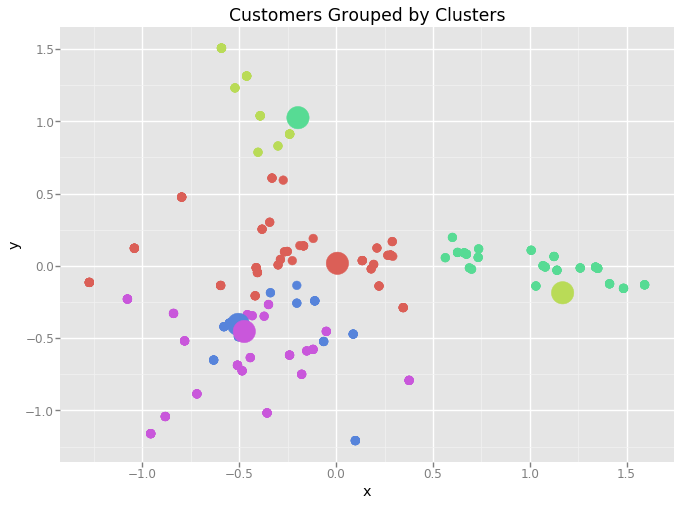

<ggplot: (-9223371952505451348)>

In [23]:
cluster_centers = pca.fit_transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

ggplot(df, aes(x='x', y='y', color='cluster')) +\
geom_point(size=75) +\
geom_point(cluster_centers, size=500) +\
ggtitle("Customers Grouped by Clusters")

#### Analyzing clusters particularities

In [24]:
df['is_4'] = df['cluster'] == 4

In [25]:
df.groupby('is_4')['varietal'].value_counts()

is_4   varietal          
False  Pinot Noir            41
       Champagne             39
       Espumante             33
       Prosecco              32
       Malbec                23
       Cabernet Sauvignon    21
       Pinot Grigio          17
       Merlot                16
       Chardonnay            11
True   Champagne             42
       Cabernet Sauvignon    11
       Prosecco              11
       Malbec                 9
       Espumante              7
       Chardonnay             4
       Merlot                 4
       Pinot Noir             3
Name: varietal, dtype: int64

#### Group 4 Likes to buy in bulk

##### If you take a look the cluster 4 min quantity mean value, they generally buy a number of products that is above the average

In [26]:
df.groupby('is_4')[['min_qty', 'discount']].mean()

min_qty   discount
is_4                       
False  51.321888  59.137339
True   76.549451  60.362637

#### One simple conclusion: send specific offers to this group